<a href="https://colab.research.google.com/github/prathameshnimkar10/cropprediction_projectacd/blob/main/ACD_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download -d killa92/crop-disease-image-classification-dataset

 99% 1.98G/2.00G [00:24<00:00, 119MB/s]
100% 2.00G/2.00G [00:24<00:00, 87.5MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/crop-disease-image-classification-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
tf.version.VERSION

'2.15.0'

In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.13.0

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 47.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.10.0
    Uninstalling typing_extensions-4.10.0:
      Successfully uninstalled typing_extensions-4.10.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation:

In [ ]:
import tensorflow as tf
tf.version.VERSION

'2.13.0'

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
class CONFIG:
  IMG_SIZE = 300,300
  IMG_SIZE_2 = 224, 224
  BATCH_SIZE = 64
  AUTO = tf.data.AUTOTUNE
  SEED = 498

data collection, reading

In [ ]:
def create_images_list(path):
  full_path = []
  img_name = []
  images = sorted(os.listdir(path))

  for i in images:
    full_path.append(os.path.join(path, i))
    img_name.append(i)
  return full_path, img_name

img_paths, img_ids = create_images_list('/content/crop_disease_dataset/images')
real_data = pd.DataFrame({'full_img_link': img_paths, 'image_id': img_ids})
full_data_from_csv = pd.read_csv('/content/crop_disease_dataset/meta_deta.csv')

final_data = real_data.copy()
final_data = final_data.merge(full_data_from_csv, on ='image_id')
print('Total real images : \t{0}'.format(final_data.shape[0]))
final_data.head()

Total real images : 	17938


,full_img_link,image_id,label
0,/content/crop_disease_dataset/images/157078263...,157078263.jpg,3
1,/content/crop_disease_dataset/images/157489353...,1574893536.jpg,3
2,/content/crop_disease_dataset/images/157501348...,1575013487.jpg,3
3,/content/crop_disease_dataset/images/157660625...,1576606254.jpg,0
4,/content/crop_disease_dataset/images/157976147...,1579761476.jpg,1


data splitting, train test

In [ ]:
train_data, test_data = train_test_split(final_data, test_size = 0.3,
                                         stratify = final_data['label'], random_state = CONFIG.SEED)

# look-up table
classes = {0:"Cassava Bacterial Blight (CBB)", 1: "Cassava Brown Streak Disease (CBSD)",
           2: "Cassava Green Mottle (CGM)",3:"Cassava Mosaic Disease (CMD)",4:"Healthy"}

train_data = train_data.sample(frac = 1, ignore_index = True, random_state = CONFIG.SEED).reset_index(drop = True)
test_data = test_data.sample(frac = 1, ignore_index = True, random_state = CONFIG.SEED).reset_index(drop = True)


print('Total training images : \t{0}'.format(train_data.shape[0]))
print('Total testing images :  \t{0}'.format(test_data.shape[0]))
# print((train_data.shape[0])*100)/(test_data.shape[0])

Total training images : 	12556
Total testing images :  	5382


In [ ]:
train_data.head()

,full_img_link,image_id,label
0,/content/crop_disease_dataset/images/295320512...,2953205129.jpg,0
1,/content/crop_disease_dataset/images/408134116...,4081341161.jpg,1
2,/content/crop_disease_dataset/images/178877559...,1788775599.jpg,3
3,/content/crop_disease_dataset/images/196622263...,1966222636.jpg,0
4,/content/crop_disease_dataset/images/362337568...,3623375685.jpg,2


tensorflow data pipeline

In [ ]:
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)

    img_efficient = tf.image.resize(img, size = (CONFIG.IMG_SIZE))
    img_efficient = tf.cast(img_efficient, tf.float32) / 255.

    img_mobilnet = tf.image.resize(img, size = (224,224))
    img_mobilnet = tf.cast(img_mobilnet, tf.float32) / 255.

    return {'efficientnet_input' :img_efficient, 'mobilenet_input':img_mobilnet}, label

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((train_data['full_img_link'], train_data['label']))
train_dataset = (train_loader.map(img_preprocessing, num_parallel_calls = CONFIG.AUTO).batch(CONFIG.BATCH_SIZE).prefetch(CONFIG.BATCH_SIZE))

test_loader = tf.data.Dataset.from_tensor_slices((test_data['full_img_link'], test_data['label']))
test_dataset = (test_loader.map(img_preprocessing, num_parallel_calls = CONFIG.AUTO).batch(CONFIG.BATCH_SIZE).prefetch(CONFIG.BATCH_SIZE))

Feature Extraction

In [ ]:
stg = tf.distribute.MirroredStrategy()

In [ ]:
# from typing_extensions import Concatenate
with stg.scope():
    efficientnet =  hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-ft1k-b3-feature-vector/versions/1")
    mobilenet =  hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-feature-vector/versions/2")

    inp_efficient = Input(shape= (*CONFIG.IMG_SIZE, 3), dtype = tf.float32, name = 'efficientnet_input')
    inp_mobilenet = Input(shape= (*CONFIG.IMG_SIZE_2, 3), dtype = tf.float32, name = 'mobilenet_input')

    X1 = efficientnet(inp_efficient)
    X2 = mobilenet(inp_mobilenet)

    X = Concatenate(axis=1)([X1, X2])

    out = Dense(1024, activation='relu', name = 'the_feature_layer')(X)

    feature_extractor_model = Model([inp_efficient, inp_mobilenet], out)
    feature_extractor_model.compile(optimizer = 'adam', loss = None, metrics = None)

    feature_extractor_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 efficientnet_input (InputL  [(None, 300, 300, 3)]        0         []                            
 ayer)                                                                                            
                                                                                                  
 mobilenet_input (InputLaye  [(None, 224, 224, 3)]        0         []                            
 r)                                                                                               
                                                                                                  
 keras_layer (KerasLayer)    (None, 1536)                 1293062   ['efficientnet_input[0][0]']  
                                                          2                                   

Dimensionality reduction

In [ ]:
# creating train features
with stg.scope():
    train_img_features = feature_extractor_model.predict(train_dataset)

197/197 [==============================] - 3539s 18s/step


In [ ]:
pca_ = PCA(790)
pca_opt = pca_.fit(train_img_features)

train_img_final_features = pca_opt.transform(train_img_features)
train_img_final_features.shape

(12556, 790)

classification svc model

In [ ]:
X_train = train_img_final_features
y_train =  train_data['label']

In [ ]:
classifier_model = SVC(kernel='rbf')

# Training SVC model with features from the feature extractor
classifier_model.fit(X_train, y_train)

SVC()

Test Results

In [ ]:
with stg.scope():
     test_features = feature_extractor_model.predict(test_dataset)

test_img_features = pca_opt.transform(test_features)

X_test = test_img_features
y_test =  test_data['label']

85/85 [==============================] - 1538s 18s/step


In [ ]:
def plot_prediction_results(model, X_data, y_data, target_names = list(classes.values())):
    pred = model.predict(X_data)

    mse = mean_squared_error(y_data, pred)
    f1 = f1_score(y_data, pred, average = 'weighted')
    acc = accuracy_score(y_data, pred)
    cm = confusion_matrix(y_data, pred)

    clf = classification_report(y_data, pred, target_names = target_names)

    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)

    print('\n Classification Report:\n',clf)
    print('--'*35)
    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay(cm, display_labels = target_names)
    fig, axs = plt.subplots(figsize=(4,4))
    cmd.plot(ax=axs, xticks_rotation="vertical", colorbar = False)

Mean Squared Error :	0.89000
Weighted F1 Score :	0.805
Accuracy Score :	81.197 %
----------------------------------------------------------------------

 Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.56      0.52      0.54       276
Cassava Brown Streak Disease (CBSD)       0.70      0.58      0.63       549
         Cassava Green Mottle (CGM)       0.83      0.55      0.66       598
       Cassava Mosaic Disease (CMD)       0.88      0.96      0.92      3309
                            Healthy       0.60      0.64      0.62       650

                           accuracy                           0.81      5382
                          macro avg       0.71      0.65      0.67      5382
                       weighted avg       0.81      0.81      0.81      5382

----------------------------------------------------------------------

 Confusion Matrix: 



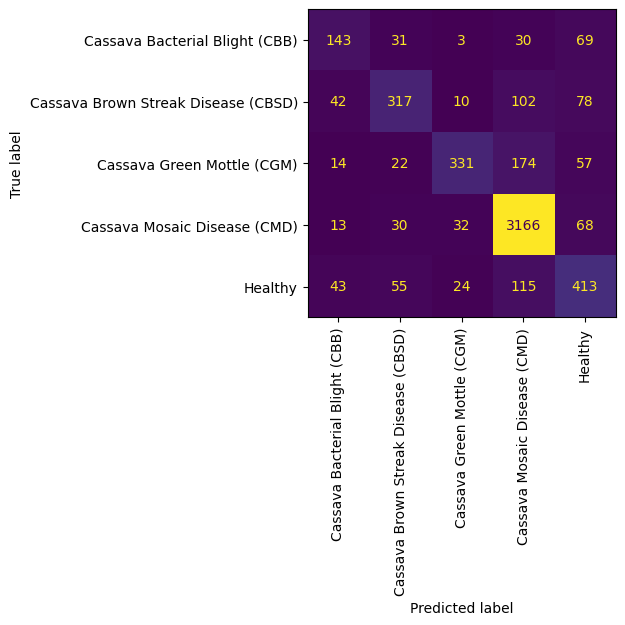

In [ ]:
plot_prediction_results(classifier_model, X_test, y_test)

Test Sample Prediction

In [ ]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

test_pred = classifier_model.predict(X_test)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // CONFIG.BATCH_SIZE
    image_idx = idxs-batch_idx * CONFIG.BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0]['efficientnet_input'][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()


        if int(test_pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

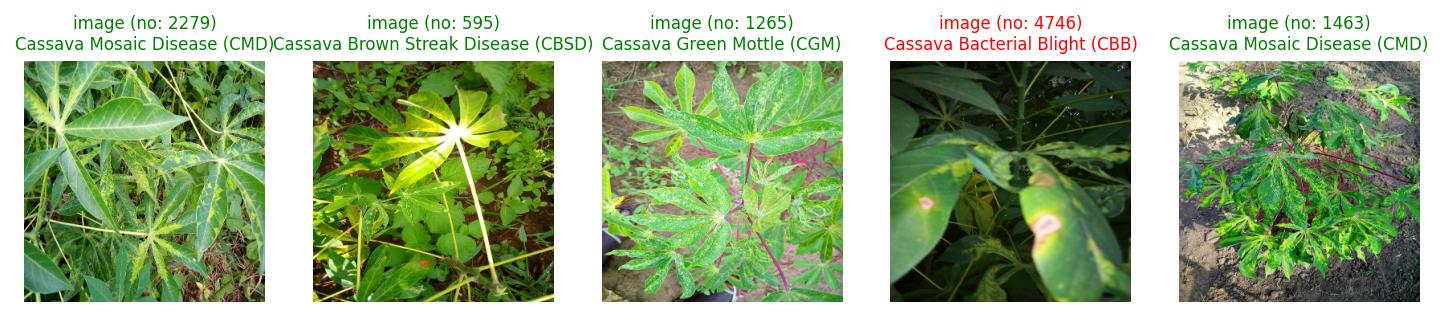

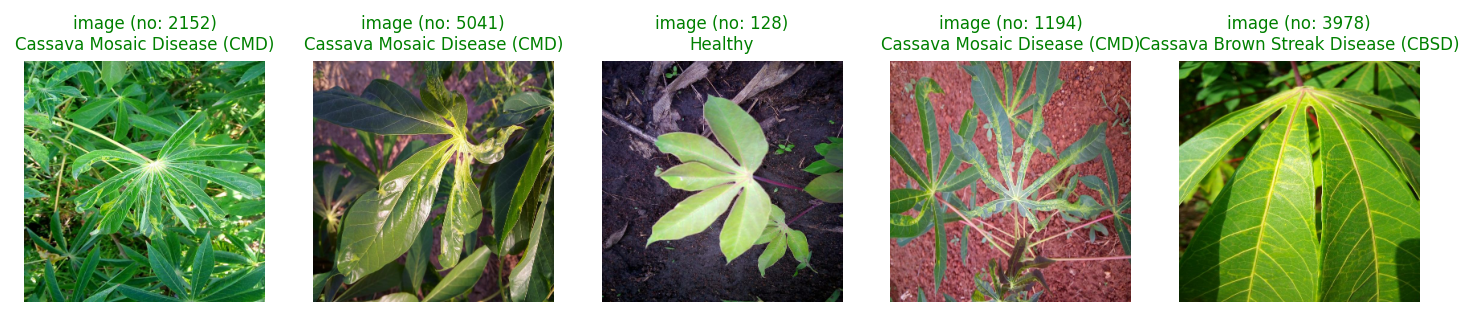

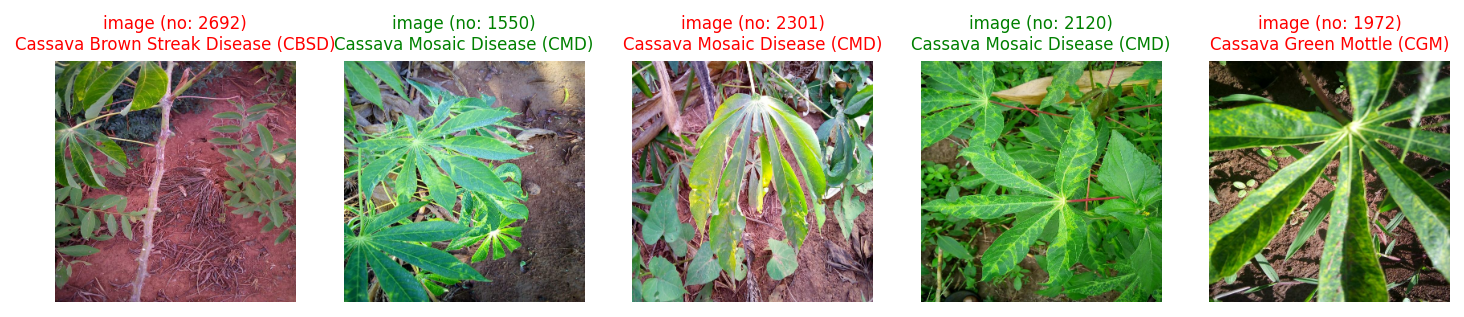

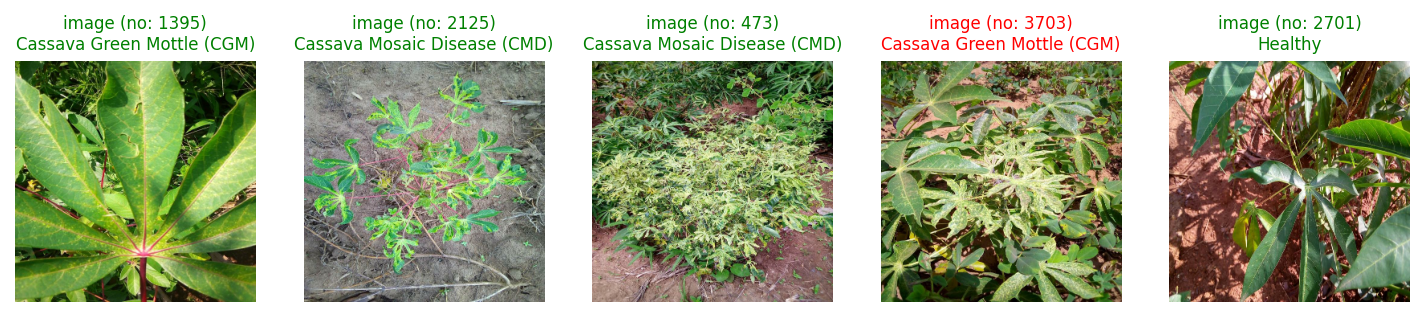

In [ ]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 33)
random_test_sample_with_prediction(SEED = 515)
random_test_sample_with_prediction(SEED = 983)
random_test_sample_with_prediction(SEED = 46)